# Ergodic Information Harvesting Tutorial
This is a tutorial about how the ergodic information harvesting strategy works. In this tutorial, an minimal ideal example is given to gradually build the intuition of each one of the key technical component of the general ergodic information harvesting algorithm.

Chen Chen

April 2018

## Table of Contents
1. [Example Description](#0.-Example-Description)
2. [Measurement Model](#1.-Measurement-Model)
3. [Likelihood](#3.-Likelihood)
4. [Bayesian Filter](#4.-Bayesian-Filter)
5. [Expected Entropy Reduction](#5.-Expected-Entropy-Reduction)

***

## 1. Example Description
To start our tutorial, let's define a scenario where we will be conducting our numerical simulation. Imagine we have a robot equipped with a microphone capable of moving along a 1D line. There is a stationary buzzer that generates constant buzz sound of the same loudness located in the same space. The microphone on the robot only gives the magnitude (*i.e.* loudness) of the sound it picks up regardless of the frequency of it, which means we don't care about the pitch of the sound at all. The task here is to move the robot along the 1D axis to take measurements and use them to estimate the real location of the buzzer.

## 2. Measurement Model

For the sake of simplicity, let's say our working space is from 0 to 1, that is, our robot can only move within the coordinate between 0 to 1, and the microphone on the robot only gives the magnitude (*i.e.* loudness) of the sound it picks up regardless of the frequency of it, which means we don't care about the pitch of the sound at all. We can mathematically translate the setup in the following way:

- A sensor (microphone), location denoted by $x$, can move freely within 1D space $x \in \mathbb{X}=[0, 1]$
- A signal source (buzzer) is fixed at a particular location within the 1D space $\theta \in [0, 1]$
- The sensor's measurement of sound loudness is denoted by $V \in \mathbb{V} = [0, 1]$, and a measurement with the sensor locate at any particular location $\hat{x}$ is denoted as $V_\hat{x}$

A measurement model serves as a proxy to help relates measured variables to latent variables. Given the definition above, the measurement model, in our case, help relate the measured **loudness of sound** to the **location of the sound source (buzzer)**. For example, receiving a numerical measurement of $0.5$ does not give us any information about where the sound source is *unless we have a measurement model of our sensor*. 

In [0]:
# Import need libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.pyplot import plot
from scipy.stats import norm, entropy, recipinvgauss
from scipy.interpolate import interp1d
from scipy.signal import convolve


# Configure Matplotlib
%matplotlib inline
#plt.rc('text', usetex=True)
#plt.rc('font', size=14)
#plt.rc('text.latex', preamble=r"\usepackage{amsmath}")

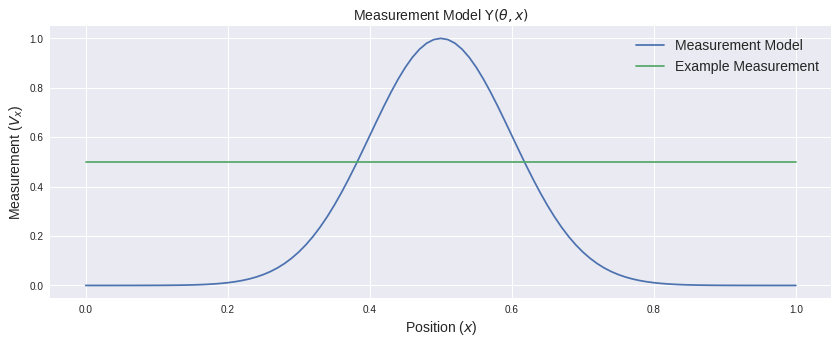

In [5]:
# Working space
wsResolution = 101 # Working space spatial resolution
wsSamples = np.linspace(0, 1, wsResolution)

# construct a measurement model with the target located at 0.5
upsilon_ = norm.pdf(wsSamples,0.5,0.1)
upsilon_ /= max(upsilon_)
upsilonInterp_ = interp1d(wsSamples, upsilon_, 'cubic')

# Finally, construct a function version of the measurement model for the use of next section
def upsilon(theta=0.5, sigmaM=0.1):
    if type(theta) is float:
        mm = norm.pdf(wsSamples,theta,sigmaM)
        mm /= max(mm)
    else:
        # Queries multiple possible target thetas
        mm = []
        for t in theta:
            mm_ = norm.pdf(wsSamples,t,sigmaM)
            mm_ /= max(mm_)
            mm.append(mm_)
        mm = np.array(mm)
    return mm
  
# Visualize the measurement model
plt.figure(figsize=(14,5));
plot(wsSamples, upsilon(0.5));
plot(wsSamples, np.tile([0.5], wsResolution))
plt.legend(('Measurement Model', 'Example Measurement'), fontsize=14, loc='best')
plt.xlabel('Position ($x$)', fontsize=14);
plt.ylabel('Measurement ($V_x$)', fontsize=14);
plt.title(r"Measurement Model $\Upsilon(\theta, x)$", fontsize=14);

The plot above shows what a generic measurement model looks like. Specifically, this is a generic symmetric Gaussian measurement model as it was generated with a Gaussian kernel in a symmetric workspace. With our microphone buzzer example, it can be interpreted as if we have the buzzer fixed at $\theta=0.5$ and move the sensor $x$ smoothly from 0 to 1 in the workspace and take consecutive measurements. Plotting all of the sensor measurements on the Y axis and sensor's location on the X axis, we will end up with the measurement model curve shown above. 

As the sensor moves closer to the buzzer's location at 0.5, we get larger measurement, and the opposite happens if we move away from 0.5. Clearly, given a measurement of $\hat{V}=0.5$, the expected location of the source can be inferred by looking up the measurement model. Drawing a green line of $V=0.5$ in the same plot, we can find two possible solutions (where the green line crosses with the blue curve) due to the symmetric property of our specific measurement model.

## 3. Likelihood

Now that we have a measurement model defined, should every sensor's measurement we get should be deterministic? For instance, should a received measurement of 0.4 always correspond to the exact same target location no matter what? The answer is certainly not given our world full of uncertainty. One of the most common form of uncertainty is measurement noise. Somewhere in the measurement process, could be the sensor itself or the analog-to-digital converter we are using or something else, noise will always be present in our measurement. Therefore, instead of getting measurements that match exactly with the measurement model, additive noise is also present.
$$
V_x = \mathbb{\Gamma}(\theta, x) + \delta 
$$
where $\mathbb{\Gamma}(\theta, x)$ is the measurement model and $\delta$ represent zero-mean Gaussian noise.

How should these uncertainty be represented in the process of inferring the latent variable (*i.e.* location of the target) using measurement model? One method is to use a Gaussian likelihood function.

### Intuituion of Likelihood Function
The likelihood function does essentially the same as our example in the measurement plot of drawing a measurement line on top of the measurement model to figure out where the target location is. The main difference is, the aformentioned approach assumes no uncertainty baecause we used only one solid line to represent measurement. In the world with uncertainty, our measurement could be in the form of $\hat{V}=0.5\pm0.1$, where 0.5 is from the measurement model and 0.1 represent the uncertainty from the Gaussian noise. This is equavalent to drawing a series of lines within $0.5\pm0.1$ and figure out a range of possible target locations. The likelihood function takes care of this transition formally by telling us how likely the target is located in a particular location given a measurement.

Now that we have defined a measurement model $\Upsilon(\hat{\theta}=0.5,x)$, we can then compute the likelihood function for a sensor to receive a measurement, for instance, $V_x=0.4$ given target $\hat{\theta}=0.5$ for all the locations $x$:
$$
P(V_x~\rvert~\hat{\theta}=0.5) = \sum_{\hat{x}}\frac{1}{\sqrt{2\pi}\sigma} \exp{[-\frac{(V_x-\Upsilon(\hat{\theta}=0.5,\hat{x}))^2}{2\sigma^2}]}
$$

For example:

The probability of sensor getting a reading Vx=0.4 at position x=0.2 given target location 0.5 is
	P(Vx=0.4|theta=0.5,x=0.2) = 0.005307456025907115


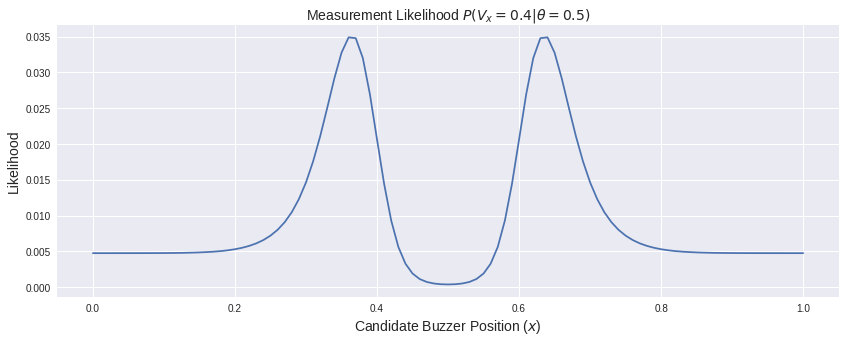

In [10]:
# Compute likelihood distribution
Vx = 0.4   # given a specific measurement
sigma = 0.2 # variance of the likelihood function
Pvx_ = ( 1.0 / (np.sqrt(2.0*np.pi) * sigma) ) * np.exp( -(Vx - upsilon_)**2 / (2.0 * sigma**2) )
Pvx_ /= sum(Pvx_)
PvxInterp_ = interp1d(wsSamples, Pvx_, 'cubic')

# Finally, construct a lambda version of the likelihood for the use of next section
Pv = lambda v: ( 1.0 / (np.sqrt(2.0*np.pi) * sigma) ) * np.exp( -(v - upsilon_)**2 / (2.0 * sigma**2) )
PvInterp = lambda v: interp1d(wsSamples, Pv(v), 'cubic')
def Pvtheta(v, theta, sigmaM=0.1, sigmaL=0.2):
  # Compute likelihood
  pvt = ( 1.0 / (np.sqrt(2.0*np.pi) * sigmaL) ) * np.exp( -(v - upsilon(theta, sigmaM))**2 / (2.0 * sigmaL**2) )
  
  # Normalize
  if pvt.ndim == 1:
    return pvt / pvt.sum()
  else:
    for idx in range(pvt.shape[0]):
      pvt[idx, :] /= pvt[idx, :].sum()
  
  return pvt

# Visualize likelihood distribution
plt.figure(figsize=(14,5))
plot(wsSamples, Pvtheta(Vx, 0.5))
plt.xlabel('Candidate Buzzer Position ($x$)', fontsize=14)
plt.ylabel(r'Likelihood', fontsize=14)
plt.title(r'Measurement Likelihood $P(V_x=0.4|\theta=0.5)$', fontsize=14)

# Which gives a map of the probability of sensor getting measurement of 0.5 given target location 0.5
print("For example:\n\nThe probability of sensor getting a reading Vx=0.4 "
      "at position x=0.2 given target location 0.5 is\n"
      "\tP(Vx=0.4|theta=0.5,x=0.2) = {0}".format(PvxInterp_(0.2)))

The above function shows the likelihood function based on a specific measurement. In this case, we know we have received a measurement $V_x=0.4$ and now we are trying to figure out where the buzzer is. Since we have a measurement model already, simply plug the measurement $V_x=0.4$ into the measurement model to query for the relative distance $x$ should answer this question. However, the measurement we received from the sensor is not perfect in reality and is always contaminated by noise or other forms of uncertainty. Therefore, the sensor receiving a measurement $V_x=0.4$ should represent a range of possible buzzer locations with different probability instead of just 1 location with 100% certainty to ensure robustness. That's the core concept of constructing the likelihood function.

Given the location of the target (*i.e.* buzzer, $\theta=0.5$) as well as a measurement $V_x=0.4$, the likelihood showed above is a function of candidate sensor location $x$ in the X axis and likelihood of this particular location lead to the received measurement in the Y axis. Together, it gives us information of how likely is the buzzer located at a particular location $x$ for all the candidate $x \in \mathcal{X}$.

## 4. Bayesian Filter

### Probability Distribution, Probability Density Function (Belief), and Entropy of the Belief
The goal of the example is to take consecutive measurements through the microphone to form a accurate estimate of the buzzer's location. Our robot's knowledge about buzzer's location can be captured in a probability distribution. We can visualize our knowledge in the form of a probability density function (PDF) $P(\theta)$ where $\theta$ is the buzzer's location we are trying to estimate. The PDF is often referred as the belief as it represents how much the robot believes the buzzer is located for all of the possible candidate positions. Let's use an example to demonstrate what belief looks like and how can it be applied to help us achieve our goal.

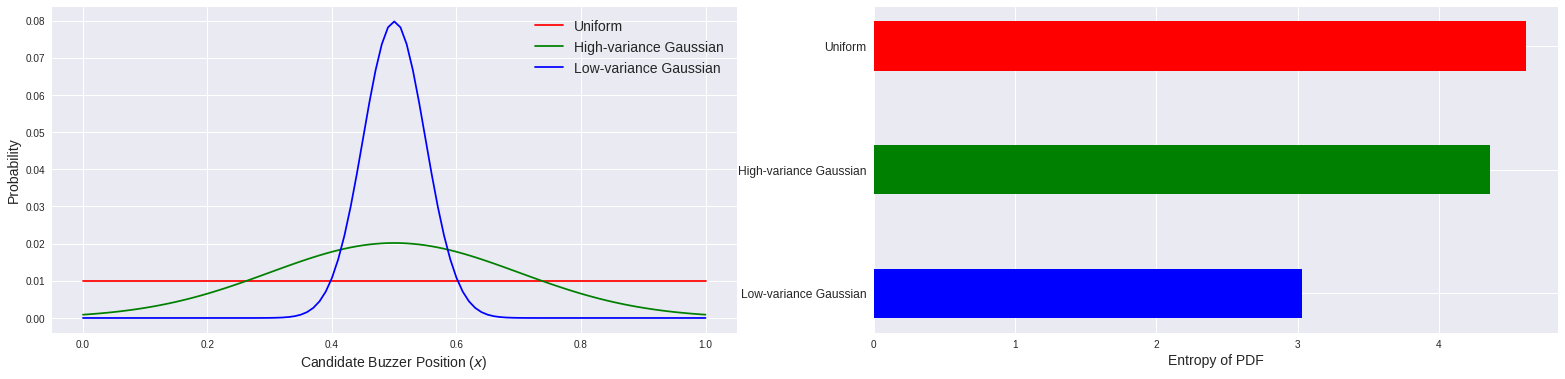

In [71]:
# Plot some PDF as example and their corresponding entropy
priorP1 = np.ones(wsResolution)/wsResolution # An uniform "uninformative" PDF
priorP3 = norm.pdf(wsSamples,0.5,0.2)        # A high-variance Gaussian PDF
priorP4 = norm.pdf(wsSamples,0.5,0.05)       # A low-variance Gaussian PDF
priorP1 /= priorP1.sum()
priorP3 /= priorP3.sum()
priorP4 /= priorP4.sum()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(27,6))
ax1.plot(wsSamples, priorP1, color='r')
ax1.plot(wsSamples, priorP3, color='g')
ax1.plot(wsSamples, priorP4, color='b')
ax1.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax1.set_ylabel(r'Probability', fontsize=14)
ax1.legend(('Uniform', 'High-variance Gaussian', 'Low-variance Gaussian'), 
           fontsize=14, loc='best');

ax2.barh([0,1,2], [entropy(priorP1), entropy(priorP3), entropy(priorP4)], height=0.4, 
        color=['r', 'g', 'b'])
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(('Uniform', 'High-variance Gaussian', 'Low-variance Gaussian'), 
                   fontsize=12)
ax2.invert_yaxis()
ax2.set_xlabel(r'Entropy of PDF', fontsize=14);

The plot above shows three different types of belief. In our case, a belief is a function of candidate buzzer position in X and probability in Y axis. We can easily encode our knowledge of the buzzer's location through the belief. Each one of the three types of belief shown above represents a unique scenario:
- **Uniform** - The probability of every candidate buzzer position matches the real buzzer location is equal. This is essentially means that our robot knows nothing about the buzzer's location.
- **High-variance Gaussian** - Our robot has a rough clue that the buzzer should be near location 0.5 because that's where the peak of the belief is, but high-variance means our belief is still very flat so we are not so sure about our guess.
- **Low-variance Gaussian** - Our robot has a fairly clear idea that the buzzer is around 0.5. This time we can make a better guess since our belief is less spread out.

Clearly, as we go from uniform to low-variance Gaussian, the robot gradually know more about where the buzzer is. This gradual improvement can be quantified by measuring the entropy of the belief shown on the right panel. The entropy is highest with the uniform belief and gradually lowers as the variance lowers in the Gaussian case. The entropy of the belief provided a proxy for us to compare different beliefs in order to determine how well is our current estimate. Recall the goal for our robot, we want to be able to estimate the location of the buzzer. However, it's unclear what exactly to do with it since we never defined what is considered "successful estimation of buzzer's location". Now, with the belief and entropy of belief defined, we can define a rigorous criteria by saying the robot is qualified to have a good estimate if the entropy of it's current belief is below a certain amount, which can be represented as
$$
S=-\sum_{} P(\theta) \log P(\theta) \leqslant \delta
$$
where $P(\theta)$ is the belief and $\delta$ is a small number.

### Recursive Bayesian Filtering
At this point, we have already defined:
- **Measurement Model $\Gamma(\theta, x)$**, which captures the intrinsic property of the sensor we have and can be used to relate measured variable, loudness of sound, to the latent variable, location of the source.
- **Likelihood Function $P(V~\rvert~\theta)$**, which quantifies where could the target be given a specific measurement received.
- **Belief $P(\theta)$**, which encodes all the information we know about the target's location in the form of a probabilistic map.

Let's say we begin with a uniform belief and let the robot take a measurement at it's current location $x_0$. Intuitively, any new measurement we got will contain some new information about where the target is and should help us improve the belief. However, the three utility we have above is not enough to let us update our belief with any new measurement. Given a measurement $V'$, we can use the measurement model to compute a (Gaussian) likelihood function. The question is how do we use the likelihood function to update our belief so the information can finally get encoded? That's where the Bayesian filter kicks in.

$$
P(\theta~\rvert~V_x) = \dfrac{P(V_x~\rvert~\theta)~P(\theta)}{P(V_x)} \propto P(V_x~\rvert~\theta)~P(\theta)
$$

where, $P(V_x~\rvert~\theta)$ is the likelihood, $P(\theta)$ is the prior belief (belief before update), and $P(\theta~\rvert~V_x)$ is the posterior belief (belief after update). Note that we only care about the structure of the belief not the scale, therefore $P(V_x)$ can be safely ignored as it only affects the scale. The equation shows how to update the belief using Bayesian inference. The recursive Bayesian filter take the same form but done resursively. For every new measurement $V_t$ at time $t$, Bayesian filter recursively updates the prior belief $P(\theta~\rvert~V_{t-1})$ with the equation above.

## 5. Expected Entropy Reduction
At this point we know how to use sensor measurements to recursively update the belief. But, does all sensor measurement has the same effect on our belief when used in the Bayesian filter? In other words, are all measurements equally informative? To answer this question, imagine two different scenarios where the robot take measurement of at location 0 and 0.5, denoted by $V_1$ and $V_2$, respectively. According to the previously defined measurement model, we have $V_1\approx0$ and $V_2\approx1$. This translates into $V_1$ tells us that "the target is probably not here" and $V_2$ tells that "the target should be near here". At this point, which measurement do you think is yields more information towards the target?

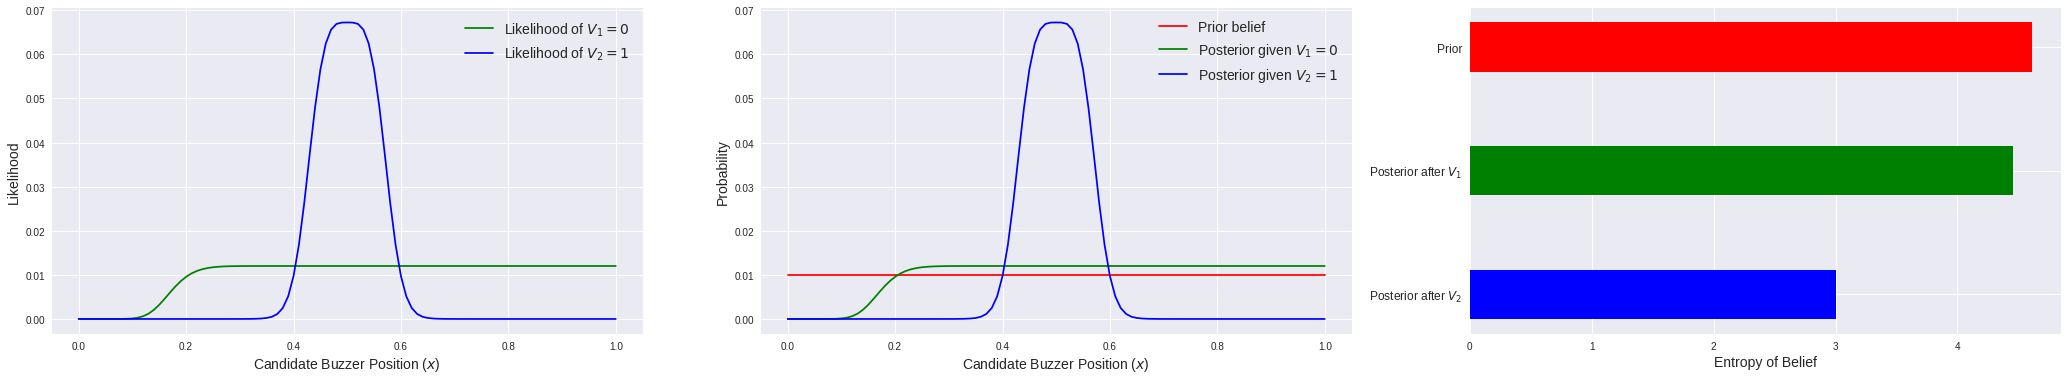

In [90]:
# Plot some PDF as example and their corresponding entropy
priorP1 = np.ones(wsResolution)/wsResolution # An uniform "uninformative" PDF
priorP1 /= priorP1.sum()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36,6))
ax1.plot(wsSamples, Pvtheta(0, 0.0), color='g', label='Likelihood of $V_1=0$')
ax1.plot(wsSamples, Pvtheta(1, 0.5), color='b', label='Likelihood of $V_2=1$')
ax1.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax1.set_ylabel(r'Likelihood', fontsize=14)
ax1.legend(fontsize=14, loc='best');

ppP1 = priorP1 * Pvtheta(0, 0.0)
ppP2 = priorP1 * Pvtheta(1, 0.5)
ppP1 /= ppP1.sum()
ppP2 /= ppP2.sum()

ax2.plot(wsSamples, priorP1, color='r', label='Prior belief')
ax2.plot(wsSamples, ppP1, color='g', label='Posterior given $V_1=0$')
ax2.plot(wsSamples, ppP2, color='b', label='Posterior given $V_2=1$')
ax2.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax2.set_ylabel(r'Probability', fontsize=14)
ax2.legend(fontsize=14, loc='best');

ax3.barh([0,1,2], [entropy(priorP1), entropy(ppP1), entropy(ppP2)], height=0.4, 
        color=['r', 'g', 'b'])
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels(('Prior', 'Posterior after $V_1$', 'Posterior after $V_2$'), 
                   fontsize=12)
ax3.invert_yaxis()
ax3.set_xlabel(r'Entropy of Belief', fontsize=14);

Clearly, $V_2$ wins. The entropy of the posterior belief after getting a measurement $V_2$ leads to a lower entropy when compared to $V_1$. This example tells us two main messages:
1. Not all measurement are equally informative. Some measurement are be more informative than others because of the location.
2. Entropy of the belief can be used as a proxy to evaluate how informative a measurement is, that is, how much information it yields.

It definitely sounds silly to let the robot radomly samples the entire workspace to take measurement. It also does not sound right for the robot to take measurement at a fixed location no matter what. Given the current belief, is there any good strategy that can help the sensor predict which location could lead to more informative measurement? The answer is yes and that is to use the expected entropy reduction (EER) method. 

### Computing Expected Entropy Reduction
As shown in the example above, entropy reduction correlates better estimation. If will be great if we can compute a map of expected entropy reduction, which is going to be in the form of expected reduction in the entropy of new posterior should the sensor take measurement at a given position. We have already demonstrated the core concept of how to achieve this above, that is to query a specific measurement assuming the target is located at a given point, compute the new hypothetical posterior and finally compute the reduction in entropy. The only problem here is that we are assuming the target location $\theta$ is known or given, which is not realistic. What we have in hand is the belief map that represent the probability distribution of our best knowledge of target's location. This means, instead of assuming a given target position while computing the hypothetical posterior for a specific measurement, we need to integrate over all of the possible target locations scaled by the corresponding probability given by the belief. This seems rather convoluted, isn't it? Let's try to break down step-by-step:

1. For each move, the sensor considers all of the possible measurement values it could get at a given location for all of the possible target locations provided by the prior belief. First we need to calculate the probability of getting a particular sensor measurement $V_x$, for all the possible measurement locations, and given the target is at $\hat{\theta}$ :

  $$
  P(V_x~\rvert~\hat{\theta}) = \sum_{\hat{x}}\frac{1}{\sqrt{2\pi}\sigma} \exp{[-\frac{(V_x-\Upsilon(\hat{\theta},\hat{x}))^2}{2\sigma^2}]}
  $$

  where $\Upsilon(\hat{\theta},\hat{x})$ is the sensor's measurement model evaluated at location $\hat{x}$ given target located at $\theta = \hat{\theta}$ 

2. The sensor then calculates how its posterior belief would change, and specifically how would the entropy of it change, should it make that move. Using Bayes update rule, the hypothetical new posterior belief $P(\theta~\rvert~V_x, \hat{x})$ is given by combining the probability of getting measurement $V_{x}$ (*i.e.* likelihood) over all possible target locations, weighted by the prior belief $P(\theta)$:

  $$
  P(\theta~\rvert~V_x,\hat{x}) = \sum_{\hat{\theta}}P(V_x, \hat{x}~\rvert~\hat{\theta})~P(\hat{\theta}~\rvert~\theta)
  $$

  where $\mathbf{\hat{x}}$ is the position the sensor would be at. $P(V_x, \hat{x}~\rvert~\hat{\theta})$ is a Gaussian likelihood probability of sensor getting measurement $V = V_x$ at location $x = \hat{x}$, given candidate target location $\theta = \hat{\theta}$, and $P(\hat{\theta}~\rvert~\theta)$ is the prior belief evaluated at location $\hat{\theta}$.

3. Given the hypothetical new posterior belief, the predicted new entropy $S$ given measurement $V_x$ can be computed for all of the possible sensor locations $x$ :

  $$
  S_{V_x} = -\sum_{} P(\theta~\rvert~V_x) \log P(\theta~\rvert~V_x)
  $$

4. Having predicted the new entropy $S_{V_x}$ given measurement $V_x$ , the agent can then compute the net entropy gain $\Delta S$ over the entire work space given all the possible measurement $V_x$, prior belief $P(\theta)$ and its entropy $S_\theta$ :

  $$
  \Delta S_{V_x} = S_\theta - S_{V_x}
  $$

5. Finally, the entropy reduction map can be derived by combining the overall likelihood probability of sensor getting a measurement state of $V_x$ given all of the possible measurement states $V_x \in \mathbb{V}$ and the expected entropy reduction should the sensor get that measurement $V_x$:

  $$
  \Delta S = \sum_{V} P(V~\rvert~\theta)~\Delta S_V
  $$

  In $\mathrm{EER}$ terms, where higher numerical value means more information gain:

  $$
  \mathrm{EER} = -\Delta S
  $$


Since we have a prior belief (posterior belief from last iteration) $P(\theta)$ which has information of how likely we believe the target is located at a given location, combining measurement likelihood over all of the possible target location given the probability of target being at that location $x$ from prior $P(\theta)$ we will have:

$$
P(V_x~\rvert~\theta) = \sum_{\hat{\theta}}P(V_x~\rvert~\hat{\theta}, x)~P(\theta~\rvert~\hat{\theta})
$$

$P(V_x~\rvert~\theta)$ is the measurement probability which is the probability of sensor getting a measurement of $V_x$ given prior $P(\theta)$

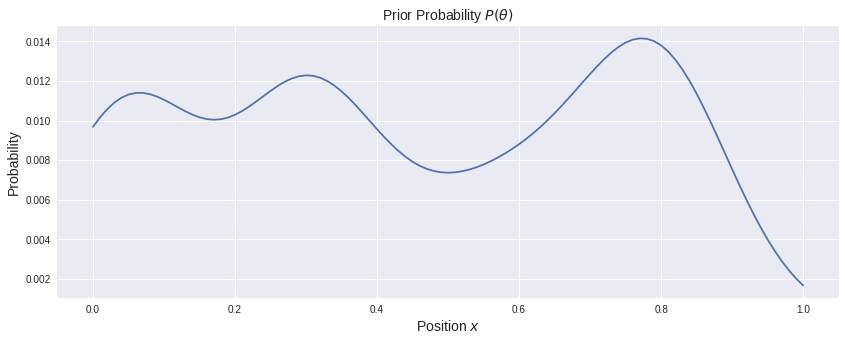

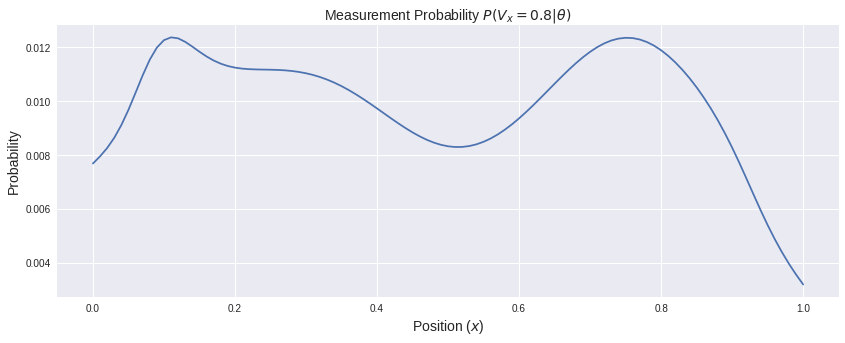

In [64]:
# Construct an arbitrary complex prior belief
#priorP = np.ones(wsResolution)
priorP = norm.pdf(wsSamples,0.8,0.1)  + norm.pdf(wsSamples,0.3,0.1) + norm.pdf(wsSamples,0.05,0.1) + norm.pdf(wsSamples,0.6,0.15) 
priorP /= sum(priorP)
# Plot prior belief
plt.figure(figsize=(14,5))
plot(wsSamples, priorP)
plt.title(r"Prior Probability $P(\theta)$", fontsize=14)
plt.xlabel("Position $x$", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Compute measurement probability Pvx over all possible sensor location
def Pvx(v, prior=priorP, sigmaM=0.1, sigmaL=0.2):
    p = Pvtheta(v, wsSamples, sigmaM, sigmaL).T * prior
    p = p.T.mean(axis=0)
    #p = Pvtheta(v, wsSamples).mean(axis=0)
    
    p /= p.sum()
    return p
  
def PvxNew(v, theta=wsSamples, prior=priorP, sigmaM=0.1, sigmaL=0.2):
  pL = Pvtheta(v, theta, sigmaM, sigmaL)
  pvx = pL
  
  for idx in range(pvx.shape[0]):
    pL[idx, :] /= pL[idx, :].sum()
    pvx[idx, :] = pvx[idx, :] * prior[idx]

  pvx = pvx.mean(axis=0)
  pvx /= pvx.sum()
  
  return pvx, pL

# Plot a example given measurement Vx=0.4
plt.figure(figsize=(14,5))
pvx, pl = PvxNew(0.8)
plot(wsSamples, pvx)
plt.title(r'Measurement Probability $P(V_x=0.8|\theta)$', fontsize=14)
plt.xlabel('Position ($x$)', fontsize=14);
plt.ylabel('Probability', fontsize=14);

Then, assume we have a prior belief $P(\theta)$ that is flat, the hypothetical posterior belief can be update as:

$$
P(\theta~\rvert~V_x) = \sum_{\hat{\theta}}P(V_x~\rvert~\hat{\theta})~P(\hat{\theta}~\rvert~\theta)
$$

where $P(\hat{\theta}~\rvert~\theta)$ is the probability of target located at $\hat{\theta}$ given prior belief $P(\theta)$. Now, new entropy can be computed given the hypothetical posterior $P(\theta~\rvert~V_x)$:

$$
S_{V_x} = -\sum_{} P(\theta~\rvert~V_x) \log P(\theta~\rvert~V_x)
$$

Given a prior belief $P(\theta)$ and its entropy $S_\theta$, the entropy gain for measurement $V_x$ is:

$$
\Delta S_{V_x} = S_\theta - S_{V_x}
$$

Then, given all of the possible measurement states $V_x \in V$:

$$
\Delta S = \sum_{V} P(V~\rvert~\theta)~\Delta S_V
$$

And in $\mathrm{EID}$ terms, where higher numerical values mean more information gain:

$$
\mathrm{EID} = -\Delta S
$$

Maximum possible entropy = 4.6151205168412615
Entropy of current prior = 4.570760331054973


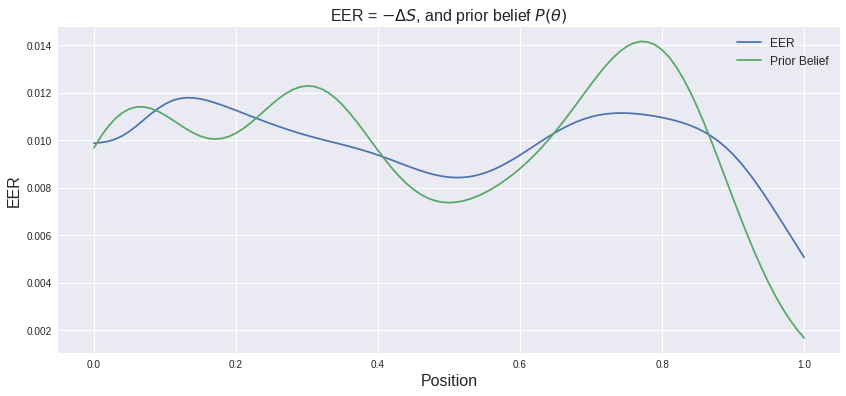

In [68]:
# Construct EER function
def EER(prior, sigmaM=0.1, sigmaL=0.2):
    # Loop through all of the possible measurement states for posterior belief and entropy
    sBase = entropy(prior)
    deltaSList = []
    deltaS = np.zeros(wsResolution)
    mmSamples = np.linspace(0,1,wsResolution)
    for mms in mmSamples:
        # Posterior
        pvx, pL = PvxNew(v=mms, prior=prior, sigmaM=sigmaM, sigmaL=sigmaL)
        pp = pL * prior

        # Entropy
        dS = entropy(pp.T) - sBase

        # Update result
        deltaSList.append(dS)
        deltaS += pvx * dS

    # Convert deltaS to Entropy EID
    EER_Entropy = -deltaS
    EER_Entropy[EER_Entropy == np.inf] = 0
    # Remove negative numbers
    if EER_Entropy.min() < 0:
        EER_Entropy -= EER_Entropy.min()
    if abs(EER_Entropy).sum() != 0:
        EER_Entropy /= abs(EER_Entropy).sum()
    
    return EER_Entropy

# Compute base entropy
sMax = entropy(np.ones(wsResolution)/wsResolution)
sBase = entropy(priorP)
print("Maximum possible entropy = {0}".format(sMax))
print("Entropy of current prior = {0}".format(sBase))

# Compute EER map
EER_Entropy = EER(priorP)

# Plot entropy map
plt.figure(figsize=(14,6))
plot(wsSamples, EER_Entropy, label='EER')
plot(wsSamples, priorP, label='Prior Belief')
plt.title(r"EER = $-\Delta S$, and prior belief $P(\theta)$", fontsize=16)
plt.xlabel("Position", fontsize=16)
plt.ylabel("EER", fontsize=16)
plt.legend(fontsize=12);

### Comparison Between Entropy and Fisher Information based EID
In this chapter, Entropy and Fisher Information based EID will be compared under different probability distributions. The goal here is to investigate the difference between Entropy and Fisher Information in the context of quantifying information gain.

Prior example 1 - flat - entropy = 4.6151205168412615
Prior example 2 - Reciprocal inverse Gaussian, low variance - entropy = 3.4031070758599844
Prior example 3 - Unimodal, centered, high variance - entropy = 4.361006466387932
Prior example 4 - Unimodal, cornered, low variance - entropy = 3.028376445638773
Prior example 5 - Bimodal, centered, high variance - entropy = 4.448656141125786
Prior example 6 - Bimodal, centered, low variance - entropy = 3.902601528409632


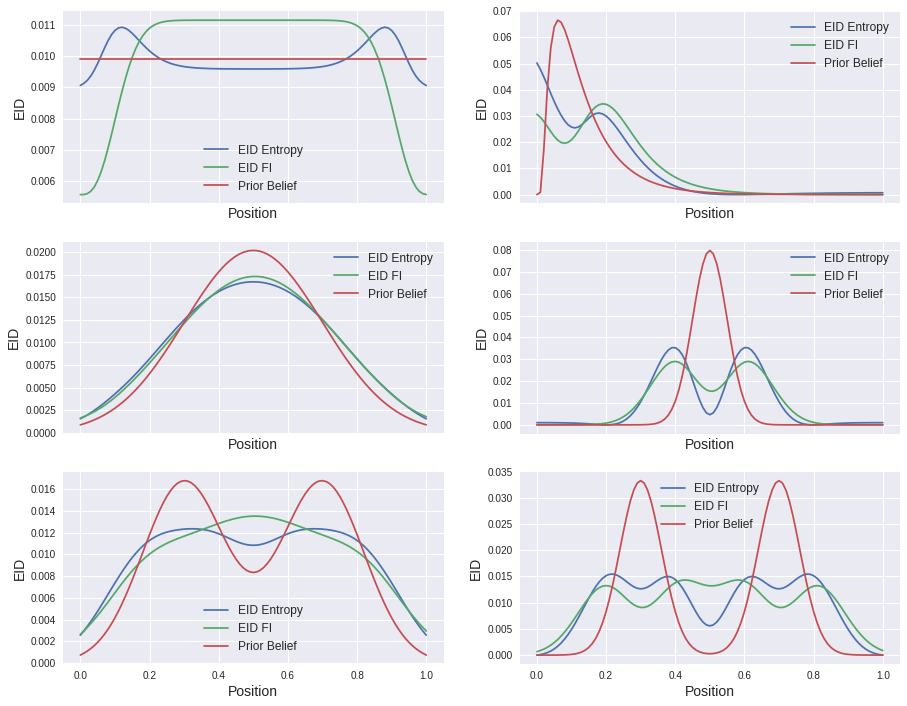

In [0]:
## Construct a variety of different prior beliefs and compute the corresponding EID maps
priorP1 = np.ones(wsResolution)/wsResolution  # Flat belief
EID_Entropy1, EID_FI1 = EID(priorP1)
print("Prior example 1 - flat - entropy = {0}".format(entropy(priorP1)))

priorP2 = recipinvgauss.pdf(wsSamples+1e-4,0.6,0,0.05)  # Reciprocal inverse Gaussian, centered, low variance
priorP2 /= priorP2.sum()
EID_Entropy2, EID_FI2 = EID(priorP2)
print("Prior example 2 - Reciprocal inverse Gaussian, low variance - entropy = {0}".format(entropy(priorP2)))

priorP3 = norm.pdf(wsSamples,0.5,0.2)  # Unimodal, centered, high variance
priorP3 /= priorP3.sum()
EID_Entropy3, EID_FI3 = EID(priorP3)
print("Prior example 3 - Unimodal, centered, high variance - entropy = {0}".format(entropy(priorP3)))

priorP4 = norm.pdf(wsSamples,0.5,0.05)  # Unimodal, centered, low variance
priorP4 /= priorP4.sum()
EID_Entropy4, EID_FI4 = EID(priorP4)
print("Prior example 4 - Unimodal, cornered, low variance - entropy = {0}".format(entropy(priorP4)))

priorP5 = norm.pdf(wsSamples,0.7,0.12) + norm.pdf(wsSamples,0.3,0.12) # Bimodal, centered, high variance
priorP5 /= priorP5.sum()
EID_Entropy5, EID_FI5 = EID(priorP5)
print("Prior example 5 - Bimodal, centered, high variance - entropy = {0}".format(entropy(priorP5)))

priorP6 = norm.pdf(wsSamples,0.7,0.06) + norm.pdf(wsSamples,0.3,0.06) # Bimodal, centered, high variance
priorP6 /= priorP6.sum()
EID_Entropy6, EID_FI6 = EID(priorP6)
print("Prior example 6 - Bimodal, centered, low variance - entropy = {0}".format(entropy(priorP6)))
   
# Build data list
priorList = [priorP1, priorP2, priorP3, priorP4, priorP5, priorP6]
eEIDList = [EID_Entropy1, EID_Entropy2, EID_Entropy3, EID_Entropy4, EID_Entropy5, EID_Entropy6]
fiEIDList = [EID_FI1, EID_FI2, EID_FI3, EID_FI4, EID_FI5, EID_FI6]

## Compare Entropy and Fisher Information on Different Priors
f, axArray = plt.subplots(3, 2, sharex='col', figsize=(15, 12))
axArray = axArray.flatten()
for idx, p in enumerate(priorList):
    axArray[idx].plot(wsSamples, eEIDList[idx], label='EER')
    axArray[idx].plot(wsSamples, fiEIDList[idx], label='EID FI')
    axArray[idx].plot(wsSamples, p, label='Prior Belief')
    axArray[idx].set_xlabel("Position", fontsize=14)
    axArray[idx].set_ylabel("EID", fontsize=14)
    axArray[idx].legend(fontsize=12, loc='best');